In [84]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px



# for preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV


# for model training
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# import model for regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

# import tensorflow for creating neural networks
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# import CatBoostClassifier
from catboost import CatBoostClassifier


# for model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score

# ignore warnings
import warnings
warnings.filterwarnings("ignore")


## Get Data

In [2]:
data = pd.read_csv('raw_data/train.csv')

In [3]:
data = data.set_index('id')

In [4]:
data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0


In [5]:
X = data.drop('Exited', axis=1)
y = data[['Exited']]

## Preproc

### Duplicates

In [6]:
len(data) # Check number of rows before removing duplicates

165034

In [7]:
X.duplicated().sum()

0

In [8]:
data = data.drop_duplicates() # Remove duplicates
len(data)# Check new number of rows

165034

### Missing Values

In [9]:
# Counting the number of NaN for each column
data.isnull().sum().sort_values(ascending=False)

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Outliers

In [10]:
data.head(1)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0


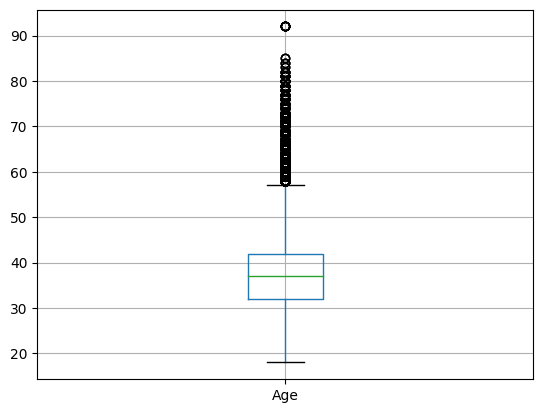

In [11]:
data[['Age']].boxplot();

In [12]:
data['Age'].max()

92.0

In [13]:
data[['CreditScore']].boxplot();

In [14]:
data['CreditScore'].min()

350

In [15]:
## Keep outliers as they make sense

### Feature Scaling

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [17]:
from sklearn.preprocessing import StandardScaler

# Step 0 - Instantiate Robust Scaler

rb_scaler = StandardScaler()

# Step 1 - Fit the scaler to the `GrLiveArea`
# to "learn" the median value and the IQR

rb_scaler.fit(X[['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard', 'IsActiveMember','EstimatedSalary']])

# Step 2 - Scale / Transform
# to apply the transformation (value - median) / IQR for every house

X[['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard', 'IsActiveMember','EstimatedSalary']] = rb_scaler.transform(X[['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard', 'IsActiveMember','EstimatedSalary']])

X.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
0,15674932,Okwudilichukwu,0.144135,France,Male,-0.578074,-0.719973,-0.883163,0.814298,0.571263,-0.99555,1.369486
1,15749177,Okwudiliolisa,-0.367706,France,Male,-0.578074,-1.432694,-0.883163,0.814298,0.571263,1.00447,-1.254085
2,15694510,Hsueh,0.268974,France,Male,0.211354,1.774548,-0.883163,0.814298,0.571263,-0.99555,1.437422
3,15741417,Kao,-0.941966,France,Male,-0.465299,-1.076334,1.486918,-1.013348,0.571263,1.00447,-0.557018
4,15766172,Chiemenam,0.743362,Spain,Male,-0.578074,-0.007253,-0.883163,0.814298,0.571263,1.00447,-1.938770


### Encoding

In [18]:
from sklearn.preprocessing import OrdinalEncoder

# Instantiate the Ordinal Encoder
ordinal_encoder = OrdinalEncoder(categories = [["Male","Female"]])

# Fit it
ordinal_encoder.fit(X[["Gender"]])

# Display the learned categories
display(ordinal_encoder.categories_)

# Transform categories into ordered numbers
X[["Gender"]] = ordinal_encoder.transform(X[["Gender"]])

# Show the transformed classes
X


[array(['Male', 'Female'], dtype=object)]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
0,15674932,Okwudilichukwu,0.144135,France,0.0,-0.578074,-0.719973,-0.883163,0.814298,0.571263,-0.99555,1.369486
1,15749177,Okwudiliolisa,-0.367706,France,0.0,-0.578074,-1.432694,-0.883163,0.814298,0.571263,1.00447,-1.254085
2,15694510,Hsueh,0.268974,France,0.0,0.211354,1.774548,-0.883163,0.814298,0.571263,-0.99555,1.437422
3,15741417,Kao,-0.941966,France,0.0,-0.465299,-1.076334,1.486918,-1.013348,0.571263,1.00447,-0.557018
4,15766172,Chiemenam,0.743362,Spain,0.0,-0.578074,-0.007253,-0.883163,0.814298,0.571263,1.00447,-1.938770
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,0.131651,Spain,1.0,-0.578074,-1.076334,-0.883163,-1.013348,0.571263,1.00447,0.382957
165030,15665521,Okechukwu,1.692140,France,0.0,-0.352523,-0.719973,-0.883163,-1.013348,-1.750507,-0.99555,0.382951
165031,15664752,Hsia,-1.141708,France,0.0,-0.803625,-0.007253,-0.883163,-1.013348,0.571263,1.00447,0.295366


In [19]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore')

# Fit encoder
ohe.fit(X[['Geography']])

# Display the detected categories
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

The categories detected by the OneHotEncoder are [array(['France', 'Germany', 'Spain'], dtype=object)]


In [20]:
# Display the generated names
print(f"The column names for the encoded values are {ohe.get_feature_names_out()}")

# Transform the current "Street" column
X[ohe.get_feature_names_out()] = ohe.transform(X[['Geography']])

# Drop the column "Street" which has been encoded
X = X.drop(columns = ['Geography'])

# Show the dataset
X.head(3)

The column names for the encoded values are ['Geography_France' 'Geography_Germany' 'Geography_Spain']


,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,0.144135,0.0,-0.578074,-0.719973,-0.883163,0.814298,0.571263,-0.99555,1.369486,1.0,0.0,0.0
1,15749177,Okwudiliolisa,-0.367706,0.0,-0.578074,-1.432694,-0.883163,0.814298,0.571263,1.00447,-1.254085,1.0,0.0,0.0
2,15694510,Hsueh,0.268974,0.0,0.211354,1.774548,-0.883163,0.814298,0.571263,-0.99555,1.437422,1.0,0.0,0.0


In [24]:
X = X.drop(columns=['CustomerId','Surname'])

### Dataset balancing

In [25]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [29]:
X_resampled.shape, y_resampled.shape

((260226, 12), (260226, 1))

In [50]:
X_resampled

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,0.144135,0.0,-0.578074,-0.719973,-0.883163,0.814298,0.571263,-0.99555,1.369486,1.0,0.0,0.0
1,-0.367706,0.0,-0.578074,-1.432694,-0.883163,0.814298,0.571263,1.00447,-1.254085,1.0,0.0,0.0
2,0.268974,0.0,0.211354,1.774548,-0.883163,0.814298,0.571263,-0.99555,1.437422,1.0,0.0,0.0
3,-0.941966,0.0,-0.465299,-1.076334,1.486918,-1.013348,0.571263,1.00447,-0.557018,1.0,0.0,0.0
4,0.743362,0.0,-0.578074,-0.007253,-0.883163,0.814298,0.571263,1.00447,-1.938770,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
260221,-0.613270,1.0,0.624652,-0.363613,1.136759,-1.013348,-1.750507,1.00447,0.258021,0.0,1.0,0.0
260222,0.734369,1.0,-0.090246,-0.836025,-0.883163,-1.013348,0.571263,-0.99555,-0.327806,1.0,0.0,0.0
260223,0.042541,0.0,0.243759,1.061827,-0.883163,-1.013348,-1.750507,-0.99555,1.099889,1.0,0.0,0.0
260224,0.735352,1.0,-0.093727,-1.317340,1.810732,-1.013348,0.571263,1.00447,1.142012,0.0,1.0,0.0


## Reduce dimensionality

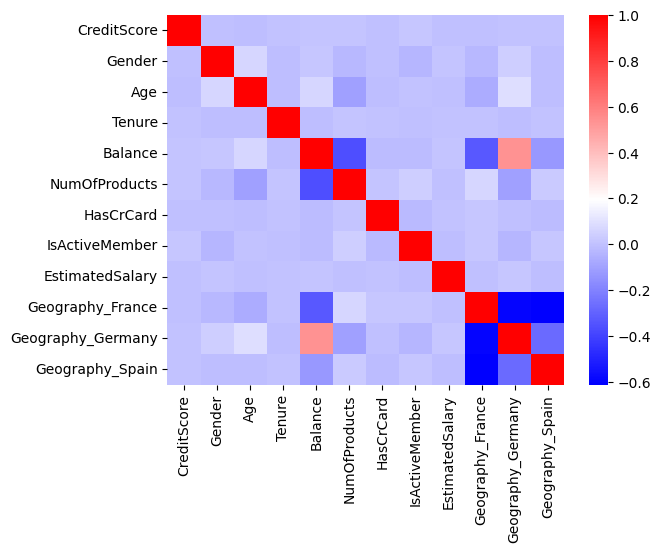

In [38]:
%matplotlib inline
import seaborn as sns

# Heatmap of pairwise correlations
correlation_matrix = X.select_dtypes('number').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr");

In [39]:
from sklearn.decomposition import TruncatedSVD

In [75]:
svd = TruncatedSVD(n_components=8)
trunc_df = svd.fit_transform(X_resampled)

In [76]:
print(svd.explained_variance_ratio_.sum())

0.9038924454152384


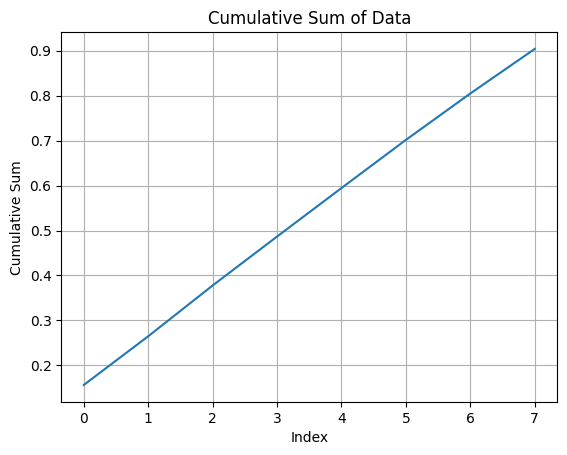

In [77]:
# Calculate the cumulative sum
cumulative_data = np.cumsum(svd.explained_variance_ratio_)

# Plot the cumulative sum
plt.plot(cumulative_data)
plt.title('Cumulative Sum of Data')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.grid(True)
plt.show()

In [80]:
trunc_df = pd.DataFrame(trunc_df, columns=[f'component_{i+1}' for i in range(trunc_df.shape[1])])
latent_df = trunc_df.set_index(X_resampled.index)
latent_df

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8
0,-0.843988,1.230298,-0.635375,0.046339,-1.465717,-0.589721,-0.872059,-0.286381
1,-1.367615,0.403611,0.249662,1.717830,0.736457,-0.799837,0.517453,-0.334214
2,-0.571886,1.563661,-1.071701,-1.722055,-0.821309,1.005838,-0.305502,-0.115415
3,0.997022,-1.135952,-0.276273,0.995718,0.403477,-1.237438,0.858281,-0.100415
4,-1.529144,-0.085356,0.016057,1.324884,1.418348,0.886855,0.257801,-0.292175
...,...,...,...,...,...,...,...,...
260221,1.712103,-0.877246,1.829458,-0.551846,-0.075565,-0.591716,0.653040,0.132190
260222,0.685281,1.055108,-0.437523,1.006886,0.025425,-0.035300,-1.058797,-1.432049
260223,0.676913,0.759897,0.878603,-2.067995,-0.276975,0.069381,-0.952887,-1.346479
260224,1.670665,-1.368745,-0.051360,1.083004,-1.786328,-0.095938,0.534560,0.081882


## Train

In [81]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [82]:
X_train, X_test, y_train, y_test = train_test_split(latent_df, y_resampled, test_size=0.2, random_state=42)

### Classifier

In [85]:
model = {
    'XGBClassifier': {
        'model': XGBClassifier(),  # XGBClassifier model instance
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),  # RandomForestClassifier model instance
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),  # GradientBoostingClassifier model instance
    },
    'CatBoostClassifier': {
        'model': CatBoostClassifier(),  # CatBoostClassifier model instance
    }
}

In [86]:
# Initialize lists to store model names and evaluation metrics
model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []

for model_name, mp in model.items():
    # Create a pipeline for the current model
    pipe = Pipeline([
        ('model', mp['model'])  # Add the model to the pipeline
    ])

    # Fit the pipeline on the training data
    pipe.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipe.predict(X_test)

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Append model name and evaluation metrics to respective lists
    model_names.append(model_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)


Learning rate set to 0.100672
0:	learn: 0.6479106	total: 112ms	remaining: 1m 51s
1:	learn: 0.6103657	total: 146ms	remaining: 1m 12s
2:	learn: 0.5808167	total: 177ms	remaining: 59s
3:	learn: 0.5572321	total: 208ms	remaining: 51.9s
4:	learn: 0.5378296	total: 242ms	remaining: 48.2s
5:	learn: 0.5243882	total: 285ms	remaining: 47.1s
6:	learn: 0.5129765	total: 310ms	remaining: 43.9s
7:	learn: 0.5022996	total: 341ms	remaining: 42.2s
8:	learn: 0.4942242	total: 362ms	remaining: 39.8s
9:	learn: 0.4867641	total: 391ms	remaining: 38.7s
10:	learn: 0.4808683	total: 415ms	remaining: 37.3s
11:	learn: 0.4757418	total: 448ms	remaining: 36.9s
12:	learn: 0.4714424	total: 487ms	remaining: 37s
13:	learn: 0.4674897	total: 510ms	remaining: 35.9s
14:	learn: 0.4636882	total: 537ms	remaining: 35.2s
15:	learn: 0.4605121	total: 564ms	remaining: 34.7s
16:	learn: 0.4584231	total: 618ms	remaining: 35.7s
17:	learn: 0.4564411	total: 659ms	remaining: 35.9s
18:	learn: 0.4546581	total: 692ms	remaining: 35.8s
19:	learn: 0.

In [87]:
# create a dataframe
evaluation_df = pd.DataFrame({
    'Model': model_name,
    'accuracy_scores': accuracy_scores,
    'precision_scores': precision_scores,
    'recall_scores': recall_scores

})
evaluation_df

,Model,accuracy_scores,precision_scores,recall_scores
0,CatBoostClassifier,0.801964,0.803488,0.799754
1,CatBoostClassifier,0.865235,0.853685,0.881750
2,CatBoostClassifier,0.791703,0.795811,0.785083
3,CatBoostClassifier,0.811244,0.812867,0.808933


### Deep Learning

In [ ]:
# %%time
# from gc import callbacks
# from tabnanny import verbose


# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 64 neurons and ReLU activation
#     tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons and ReLU activation
#     tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons and ReLU activation
#     tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons and ReLU activation
#     tf.keras.layers.Dense(16, activation='relu'),  # Hidden layer with 16 neurons and ReLU activation
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron (for regression) and linear activation
# ])

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# early_stopping = EarlyStopping(
#     monitor='val_accuracy',
#     patience=10
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=100,
#     callbacks=[early_stopping],
#     batch_size=32,
#     verbose=2,
#     validation_data=[X_test, y_test]
# )